In [34]:
__all__ = ['DataLoader']

import numpy as np
import pandas as pd
from itertools import permutations
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image
from pathlib import Path
# train_set = pd.read_csv('../train.csv')
# valid_set = pd.read_csv('../valid.csv')
# data_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/EM/training/trainsets/hr/')

class DataLoader(Dataset):
    def __init__(self, data_pth, img_size=256, patch_size=150):
#         self.img_list = list(data_pth.glob('*.tif'))
        self.img_list = data_pth.values.reshape(-1).tolist()
        self.permutations = list(permutations([0,1,2,3]))
        self.__resize = transforms.Compose([
            transforms.Resize(img_size, Image.BILINEAR),
            transforms.CenterCrop(img_size)
        ])
        self.croplist = [[0, 0, patch_size, patch_size],
                     [0, img_size-patch_size, patch_size, img_size],
                     [img_size-patch_size, 0, img_size, patch_size],
                     [img_size-patch_size, img_size-patch_size, img_size, img_size]]
        self.__augment_tile = transforms.Compose([
#             transforms.RandomCrop(patch_size),
            transforms.ToTensor(),
        ])
    
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, index):
        img_name = self.img_list[index]
        img = Image.open(img_name).convert('L')
        img = self.__resize(img)
        tiles = [None]*4
        
        for n in range(4):
            tile = img.crop(self.croplist[n])
            tile = self.__augment_tile(tile)
            # Normalize the patches indipendently to avoid low level features shortcut
            m, s = tile.mean(), tile.std()
            norm = transforms.Normalize(mean=m.view(1), std=s.view(1))
            tile = norm(tile)
            tiles[n] = tile

        order = np.random.randint(len(self.permutations))
        data = [tiles[self.permutations[order][t]] for t in range(4)]
        data = torch.stack(data, 0)
        return data, img
        self.x = data
        self.y = int(order)
        return self.x, self.y
    
# jigsaw_train = DataLoader(train_set)
# jigsaw_valid = DataLoader(valid_set)

In [22]:
import matplotlib.pyplot as plt

In [29]:
train_set = pd.read_csv('../train.csv')
ds = DataLoader(train_set, patch_size=150)

In [30]:
x, orig = ds[80]
x = torch.cat(tuple(x.squeeze()), 1)

In [32]:
x.size()

torch.Size([150, 600])

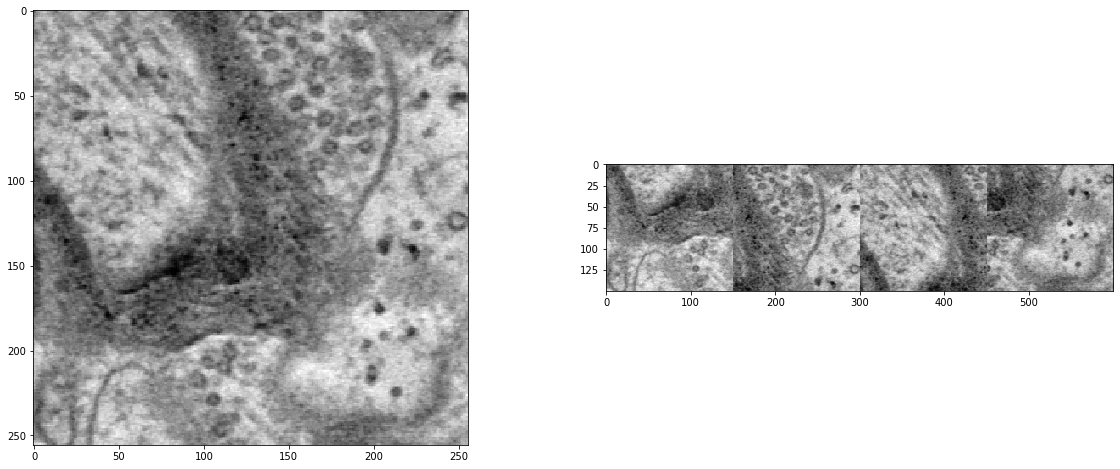

In [33]:
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
plt.imshow(orig, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(x, cmap='gray')

## slicing

In [14]:
index=80
img_size=256
patch_size=150
img_list = train_set.values.reshape(-1).tolist()

__resize = transforms.Compose([
            transforms.Resize(img_size, Image.BILINEAR),
            transforms.CenterCrop(img_size)])

img_name = img_list[index]
img = Image.open(img_name).convert('L')
img = __resize(img)
h, w = img.size
half_h, half_w = int(h/2), int(w/2)
croplist = [[0, 0, patch_size, patch_size],
 [0, img_size-patch_size, patch_size, img_size],
 [img_size-patch_size, 0, img_size, patch_size],
 [img_size-patch_size, img_size-patch_size, img_size, img_size]]

## testing output of conv

In [60]:
def forward(x):
        B,T,C,H,W = x.size()
        print(B, T, C, H, W)
        x = x.transpose(0,1)
        print(x.shape)
        x_list = []
        for i in range(4):
            z = net.conv(x[i])
            print(z.shape)
#             return z
            z = net.fc6(z.view(B,-1))
            z = z.view([B,1,-1])
            x_list.append(z)

        x = cat(x_list,1)
        x = net.fc7(x.view(B,-1))
        x = net.classifier(x)

        return x

In [61]:
z = forward(image)

16 4 1 97 97
torch.Size([4, 16, 1, 97, 97])
torch.Size([16, 256, 4, 4])
torch.Size([16, 256, 4, 4])
torch.Size([16, 256, 4, 4])
torch.Size([16, 256, 4, 4])


In [62]:
z.shape

torch.Size([16, 1000])

In [59]:
z.view(16,-1).shape

torch.Size([16, 4096])

In [54]:
net = Network()

In [55]:
# %debug
net(image)

tensor([[ 0.8485,  0.2048,  0.6641,  ..., -0.0944,  0.6329, -0.3179],
        [ 1.3378, -0.8184,  0.5933,  ...,  0.4421,  0.4957,  0.1055],
        [ 0.3824, -0.5121, -0.2763,  ...,  0.5391,  0.4875, -0.1170],
        ...,
        [ 1.1880, -0.9379, -0.0575,  ...,  0.4014,  0.7423,  0.7638],
        [ 0.4964, -0.1386,  0.8170,  ..., -0.2357,  0.8840,  0.1085],
        [ 1.0524, -0.6193,  0.4974,  ..., -0.0999,  0.3870, -0.2325]],
       grad_fn=<AddmmBackward>)

In [53]:
import torch
import torch.nn as nn
from torch import cat
import torch.nn.init as init

class Network(nn.Module):

    def __init__(self, classes=1000):
        super(Network, self).__init__()

        self.conv = nn.Sequential()
        self.conv.add_module('conv1_s1',nn.Conv2d(1, 96, kernel_size=11, stride=2, padding=0))
        self.conv.add_module('relu1_s1',nn.ReLU(inplace=True))
        self.conv.add_module('pool1_s1',nn.MaxPool2d(kernel_size=3, stride=2))
        self.conv.add_module('lrn1_s1',LRN(local_size=5, alpha=0.0001, beta=0.75))

        self.conv.add_module('conv2_s1',nn.Conv2d(96, 256, kernel_size=5, padding=2, groups=2))
        self.conv.add_module('relu2_s1',nn.ReLU(inplace=True))
        self.conv.add_module('pool2_s1',nn.MaxPool2d(kernel_size=3, stride=2))
        self.conv.add_module('lrn2_s1',LRN(local_size=5, alpha=0.0001, beta=0.75))

        self.conv.add_module('conv3_s1',nn.Conv2d(256, 384, kernel_size=3, padding=1))
        self.conv.add_module('relu3_s1',nn.ReLU(inplace=True))

        self.conv.add_module('conv4_s1',nn.Conv2d(384, 384, kernel_size=3, padding=1, groups=2))
        self.conv.add_module('relu4_s1',nn.ReLU(inplace=True))

        self.conv.add_module('conv5_s1',nn.Conv2d(384, 256, kernel_size=3, padding=1, groups=2))
        self.conv.add_module('relu5_s1',nn.ReLU(inplace=True))
        self.conv.add_module('pool5_s1',nn.MaxPool2d(kernel_size=3, stride=2))

        self.fc6 = nn.Sequential()
        self.fc6.add_module('fc6_s1',nn.Linear(256*4*4, 1024))
        self.fc6.add_module('relu6_s1',nn.ReLU(inplace=True))
        self.fc6.add_module('drop6_s1',nn.Dropout(p=0.5))

        self.fc7 = nn.Sequential()
        self.fc7.add_module('fc7',nn.Linear(4*1024,4096))
        self.fc7.add_module('relu7',nn.ReLU(inplace=True))
        self.fc7.add_module('drop7',nn.Dropout(p=0.5))

        self.classifier = nn.Sequential()
        self.classifier.add_module('fc8',nn.Linear(4096, classes))
        
        self.apply(weights_init)

    def load(self,checkpoint):
        model_dict = self.state_dict()
        pretrained_dict = torch.load(checkpoint)
        pretrained_dict = {k: v for k, v in list(pretrained_dict.items()) if k in model_dict and 'fc8' not in k}
        model_dict.update(pretrained_dict)
        self.load_state_dict(model_dict)
        print([k for k, v in list(pretrained_dict.items())])

    def save(self, checkpoint):
        torch.save(self.state_dict(), checkpoint)
        print(f'Model saved: {checkpoint}')
    
    def forward(self, x):
        B,T,C,H,W = x.size()
        x = x.transpose(0,1)

        x_list = []
        for i in range(4):
            z = self.conv(x[i])
            z = self.fc6(z.view(B,-1))
            z = z.view([B,1,-1])
            x_list.append(z)

        x = cat(x_list,1)
        x = self.fc7(x.view(B,-1))
        x = self.classifier(x)

        return x


def weights_init(model):
    if type(model) in [nn.Conv2d,nn.Linear]:
        nn.init.xavier_normal_(model.weight.data)
        nn.init.constant_(model.bias.data, 0.1)

class LRN(nn.Module):
    def __init__(self, local_size=1, alpha=1.0, beta=0.75, ACROSS_CHANNELS=True):
        super(LRN, self).__init__()
        self.ACROSS_CHANNELS = ACROSS_CHANNELS
        if ACROSS_CHANNELS:
            self.average=nn.AvgPool3d(kernel_size=(local_size, 1, 1),
                    stride=1,padding=(int((local_size-1.0)/2), 0, 0))
        else:
            self.average=nn.AvgPool2d(kernel_size=local_size,
                    stride=1,padding=int((local_size-1.0)/2))
        self.alpha = alpha
        self.beta = beta


    def forward(self, x):
        if self.ACROSS_CHANNELS:
            div = x.pow(2).unsqueeze(1)
            div = self.average(div).squeeze(1)
            div = div.mul(self.alpha).add(1.0).pow(self.beta)
        else:
            div = x.pow(2)
            div = self.average(div)
            div = div.mul(self.alpha).add(1.0).pow(self.beta)
        x = x.div(div)
        return x

# dev

In [32]:
import matplotlib.pyplot as plt

In [2]:
from fastai.vision import DataBunch

In [3]:
db = DataBunch.create(train_ds=ds, valid_ds=None)

NameError: name 'DataBunch' is not defined

In [3]:
class DataLoader(Dataset):
    def __init__(self, data_pth):
        self.img_list = list(data_pth.glob('*.tif'))

        self.permutations = self.__retrive_permutations()

        self.__resize = transforms.Resize(256, Image.BILINEAR)
        self.__augment_tile = transforms.Compose([
            transforms.RandomCrop(64),
            transforms.Resize((75, 75), Image.BILINEAR),
            transforms.ToTensor(),
        ])
    
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, index):
        img_name = self.img_list[index]
        img = Image.open(img_name).convert('L')
        img = self.__resize(img)

        s = float(img.size[0]) / 2
        a = s / 2
        tiles = [None] * 4
        for n in range(4):
            i = n / 2
            j = n % 2
            c = [a * i * 2 + a, a * j * 2 + a]
            c = np.array([c[1] - a, c[0] - a, c[1] + a + 1, c[0] + a + 1]).astype(int)
            tile = img.crop(c.tolist())
            tile = self.__augment_tile(tile)
            # Normalize the patches indipendently to avoid low level features shortcut
            m, s = tile.mean(), tile.std()
            norm = transforms.Normalize(mean=m.view(1), std=s.view(1))
            tile = norm(tile)
            tiles[n] = tile

        order = np.random.randint(len(self.permutations))
        data = [tiles[self.permutations[order][t]] for t in range(9)]
        data = torch.stack(data, 0)
        self.x = data
        self.y = int(order)
        return self.x, self.y

    def __retrive_permutations(self):
        all_perm = np.load('permutations_1000.npy')
        return all_perm

In [139]:
dataloader = DataLoader(jigsaw_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

TypeError: __init__() got an unexpected keyword argument 'batch_size'

In [35]:
img_file

PosixPath('/home/alaa/Dropbox/BPHO Staff/USF/EM/training/trainsets/hr/EM_train_hr_61500.tif')

In [36]:
img = Image.open(img_file).convert('L')

In [38]:
__image_transformer = transforms.Compose([
            transforms.Resize(256, Image.BILINEAR),
            transforms.CenterCrop(255)])
img = __image_transformer(img)

In [41]:
img.size

(255, 255)

In [42]:
totensor = transforms.ToTensor()

In [43]:
img = totensor(img)

In [46]:
img.view(1, -1).shape

torch.Size([1, 65025])

In [45]:
img.shape

torch.Size([1, 255, 255])

In [51]:
m = img.mean()

In [52]:
s = img.std()

In [60]:
s.view(1)

tensor([0.1002])

In [61]:
norm = transforms.Normalize(mean=m.view(1), std=s.view(1))

In [31]:
# %debug
xb, yb = db.one_batch()

In [ ]:
shuffled, original = xb[0]
indices = yb[0]
print(indices+1)
plt.figure(figsize=(20,20))
plt.tight_layout()
plt.subplot(1,2,1)
plt.imshow(shuffled[0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(original[0], cmap='gray')
plt.show()

0 torch.Size([4, 600, 900])
1 torch.Size([4, 600, 900])
2 torch.Size([4, 600, 900])
3 torch.Size([4, 600, 900])


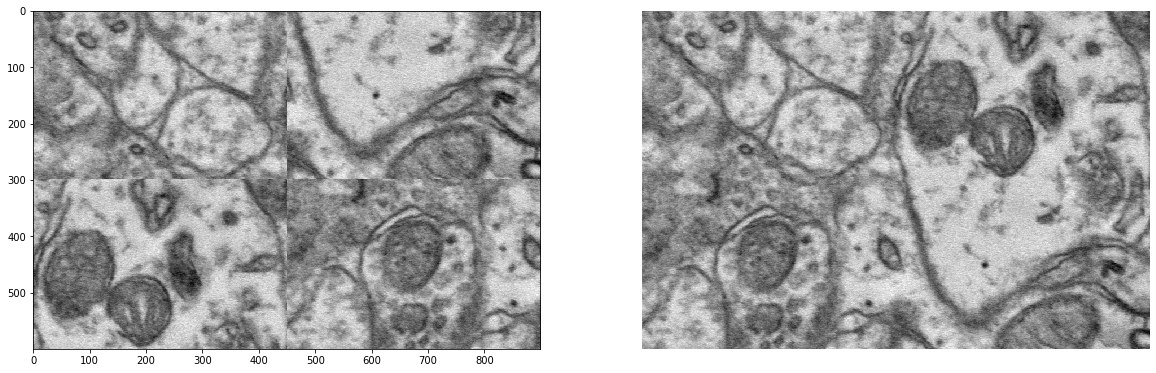

In [64]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['shuffled'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure(figsize=(20,20))
        plt.subplot(1,2,1)
        plt.imshow(sample_batched['shuffled'][3], cmap='gray')
        plt.subplot(1,2,2)
        plt.imshow(sample_batched['original'][3], cmap='gray')
        plt.axis('off')
        plt.ioff()
        plt.show()
        break